In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from time import time
import gensim
import sqlite3

#metrics 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

import pickle
#functions for reading and saving files

def save(obj,fn):
    pickle.dump(obj,fn+".p","wb")
    
def read(fn):
    return pickle.load(fn+".p","rb")

In [2]:
#reading file and creating dataframe
df=pd.read_csv("final.csv")
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud- nice rhythm well ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
#sorting dataframe by time
df.sort_values("Time",inplace=True)
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## unigram

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#breaking data into train and test

X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to unigram
unigram=CountVectorizer()

X_train=unigram.fit_transform(X_train)
X_test=unigram.transform(X_test)

#normalize

X_train=preprocessing.normalize(X_train)
X_test=preprocessing.normalize(X_test)

print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (254921, 94044)
shape of test  (109252, 94044)


In [5]:
#10 fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)
for train,cv in tscv.split(X_train):
    print(X_train[train].shape,X_train[cv].shape)
    

(23181, 94044) (23174, 94044)
(46355, 94044) (23174, 94044)
(69529, 94044) (23174, 94044)
(92703, 94044) (23174, 94044)
(115877, 94044) (23174, 94044)
(139051, 94044) (23174, 94044)
(162225, 94044) (23174, 94044)
(185399, 94044) (23174, 94044)
(208573, 94044) (23174, 94044)
(231747, 94044) (23174, 94044)


In [13]:
#multinomial NAive_Bayes
#finding right alpha
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb=MultinomialNB()
param_grid={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
gsv=GridSearchCV(mnb,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,Y_train)

print("best Hyperparameter :",gsv.best_params_)
print("best auc : ",gsv.best_score_*100)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best Hyperparameter : {'alpha': 0.01}
best auc :  91.82708634417797


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   30.8s finished


In [14]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

In [15]:
train_auc

array([0.97507351, 0.97381041, 0.97135701, 0.96592925, 0.95025406,
       0.86277399, 0.70989316, 0.66303122, 0.64405869, 0.62680936])

In [16]:
alpha1=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
X=np.log(alpha1)
X

array([-11.51292546,  -9.21034037,  -6.90775528,  -4.60517019,
        -2.30258509,   0.        ,   2.30258509,   4.60517019,
         6.90775528,   9.21034037])

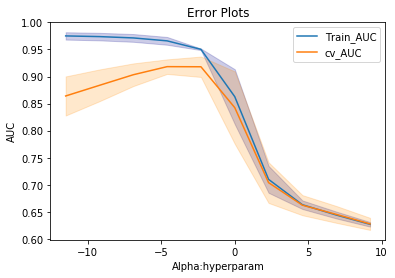

In [19]:
plt.plot(X,train_auc,label="Train_AUC")
plt.gca().fill_between(X,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(X,cv_auc,label="cv_AUC")
plt.gca().fill_between(X,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [35]:
#testing on test data

mnb=MultinomialNB(alpha=0.01)
mnb.fit(X_train,Y_train)
Y_pred1=mnb.predict(X_train)
Y_pred2=mnb.predict(X_test)

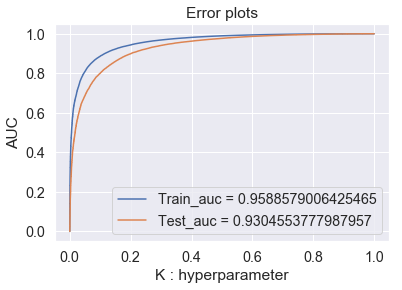

In [36]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,mnb.predict_proba(X_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,mnb.predict_proba(X_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("K : hyperparameter")
plt.ylabel("AUC")
plt.title("Error plots")
plt.show()

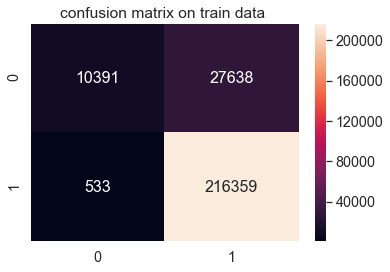

In [37]:
plt.title("confusion matrix on train data ")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.3)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

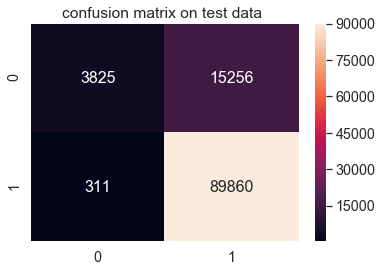

In [38]:
plt.title("confusion matrix on test data ")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.3)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [48]:
print(mnb.coef_[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [41]:
#top positive and negative words
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tnegative   \t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(unigram,mnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			negative   				Positive
________________________________________________________________________________________________
	-18.4931	000001         				-4.4490	tast           
	-18.4931	00001          				-4.4589	like           
	-18.4931	000013         				-4.4716	love           
	-18.4931	0001           				-4.4822	great          
	-18.4931	00227          				-4.5158	good           
	-18.4931	005            				-4.6345	flavor         
	-18.4931	0069615        				-4.7552	product        
	-18.4931	00come         				-4.7587	use            
	-18.4931	00complet      				-4.8296	one            
	-18.4931	00from         				-4.9291	tri            
	-18.4931	00http         				-4.9465	tea            
	-18.4931	00i            				-4.9947	coffe          
	-18.4931	00order        				-5.0408	make           
	-18.4931	00servic       				-5.1059	get            
	-18.4931	00that         				-5.2547	buy            
	-18.4931	00what         				-5.2838	best           
	-18.4931	00would        			

## Bigram

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254921, 2573473)
Test Data Size:  (109252, 2573473)


In [47]:
mnb=MultinomialNB()
gsv=GridSearchCV(mnb,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,Y_train)
print("best hyperparameter :",gsv.best_params_)
print("best score %.2ff%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  5.3min finished


best hyperparameter : {'alpha': 0.01}
best score 92.17f%


In [49]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

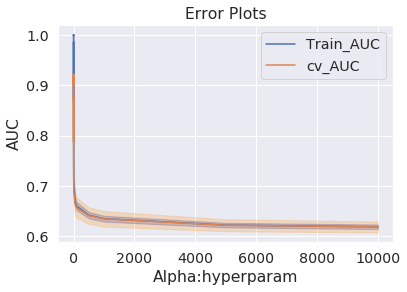

In [51]:
plt.plot(alpha1,train_auc,label="Train_AUC")
plt.gca().fill_between(alpha1,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha1,cv_auc,label="cv_AUC")
plt.gca().fill_between(alpha1,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [52]:
#testing on test data

mnb=MultinomialNB(alpha=0.01)
mnb.fit(X_train,Y_train)
Y_pred1=mnb.predict(X_train)
Y_pred2=mnb.predict(X_test)

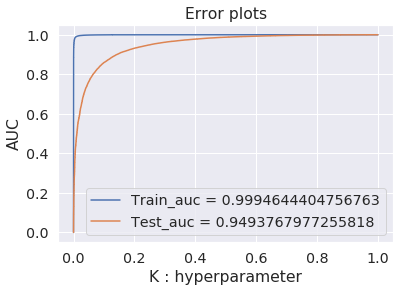

In [53]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,mnb.predict_proba(X_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,mnb.predict_proba(X_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("K : hyperparameter")
plt.ylabel("AUC")
plt.title("Error plots")
plt.show()

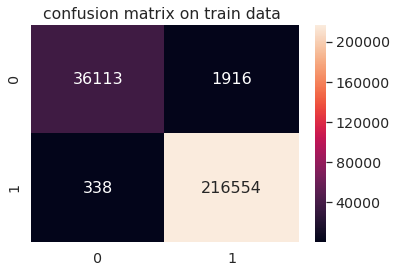

In [54]:
plt.title("confusion matrix on train data ")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.3)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

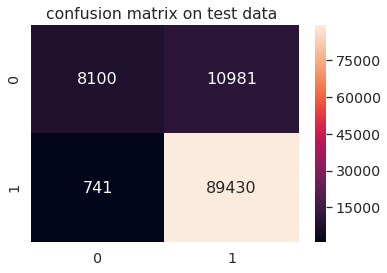

In [55]:
plt.title("confusion matrix on test data ")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.3)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [56]:
#top positive and negative words
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tnegative   \t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,mnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			negative   				Positive
________________________________________________________________________________________________
	-18.9048	00 108         				-5.1399	tast           
	-18.9048	00 200         				-5.1453	like           
	-18.9048	00 32          				-5.1714	love           
	-18.9048	00 34          				-5.1830	great          
	-18.9048	00 3x          				-5.2110	good           
	-18.9048	00 400         				-5.3231	flavor         
	-18.9048	00 67          				-5.4464	use            
	-18.9048	00 68          				-5.4529	product        
	-18.9048	00 7500        				-5.5176	one            
	-18.9048	00 83          				-5.6180	tea            
	-18.9048	00 absolut     				-5.6183	tri            
	-18.9048	00 advertis    				-5.6739	coffe          
	-18.9048	00 ajar        				-5.7304	make           
	-18.9048	00 allow       				-5.7976	get            
	-18.9048	00 alreadi     				-5.9533	buy            
	-18.9048	00 amful       				-5.9825	best           
	-18.9048	00 anyconveni  			

# Tfidf

In [57]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

#breaking into train and test
X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to tfidf
tfidf=TfidfVectorizer()
X_train=tfidf.fit_transform(X_train)
X_test=tfidf.transform(X_test)

#normalize
X_train=preprocessing.normalize(X_train)
X_test=preprocessing.normalize(X_test)

print("shape of train :",X_train.shape)
print("shape of test :",X_test.shape)

shape of train : (254921, 94044)
shape of test : (109252, 94044)


In [58]:
#multinomialNB
mnb=MultinomialNB()
gsv=GridSearchCV(mnb,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,Y_train)
print("best hyperparameter :",gsv.best_params_)
print("best accuracy %.2ff%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best hyperparameter : {'alpha': 0.05}
best accuracy 89.46f%


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   56.5s finished


In [60]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

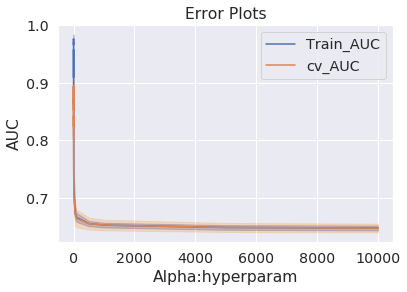

In [61]:
plt.plot(alpha1,train_auc,label="Train_AUC")
plt.gca().fill_between(alpha1,train_auc-train_auc_std,train_auc+train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha1,cv_auc,label="cv_AUC")
plt.gca().fill_between(alpha1,cv_auc-cv_auc_std,cv_auc+cv_auc_std,alpha=0.2,color="darkorange")

plt.legend()
plt.xlabel("Alpha:hyperparam")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [59]:
#testing on test data
mnb=MultinomialNB(alpha=0.05)
mnb.fit(X_train,Y_train)
Y_pred1=mnb.predict(X_train)
Y_pred2=mnb.predict(X_test)

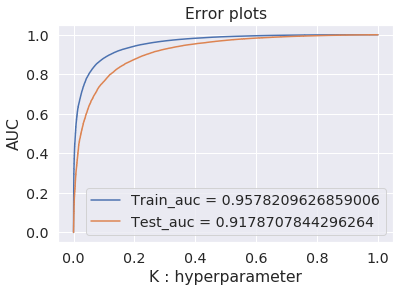

In [62]:
train_fpr,train_tpr,threshold=roc_curve(Y_train,mnb.predict_proba(X_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,mnb.predict_proba(X_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("K : hyperparameter")
plt.ylabel("AUC")
plt.title("Error plots")
plt.show()

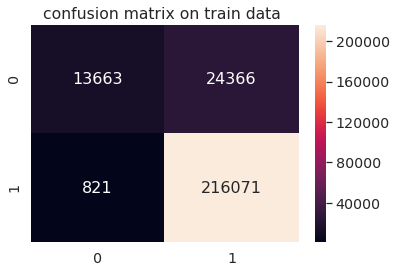

In [63]:
plt.title("confusion matrix on train data ")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.3)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

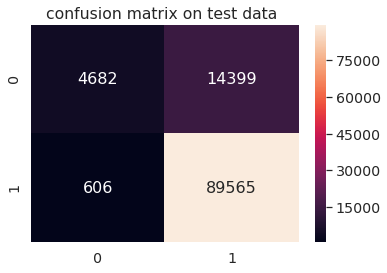

In [64]:
plt.title("confusion matrix on test data ")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.3)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

In [65]:
#top positive and negative words
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tnegative\t\t\t\t\t\tpositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,mnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			negative						positive
________________________________________________________________________________________________
	-16.8470	000001         				-5.1165	great          
	-16.8470	00001          				-5.1313	love           
	-16.8470	000013         				-5.1902	tast           
	-16.8470	0001           				-5.1923	good           
	-16.8470	00227          				-5.2128	like           
	-16.8470	005            				-5.2189	tea            
	-16.8470	0069615        				-5.2593	flavor         
	-16.8470	00come         				-5.2996	coffe          
	-16.8470	00complet      				-5.3655	product        
	-16.8470	00from         				-5.3833	use            
	-16.8470	00http         				-5.4660	one            
	-16.8470	00i            				-5.5355	tri            
	-16.8470	00order        				-5.5983	make           
	-16.8470	00servic       				-5.6617	get            
	-16.8470	00that         				-5.6946	price          
	-16.8470	00what         				-5.6972	best           
	-16.8470	00would        				

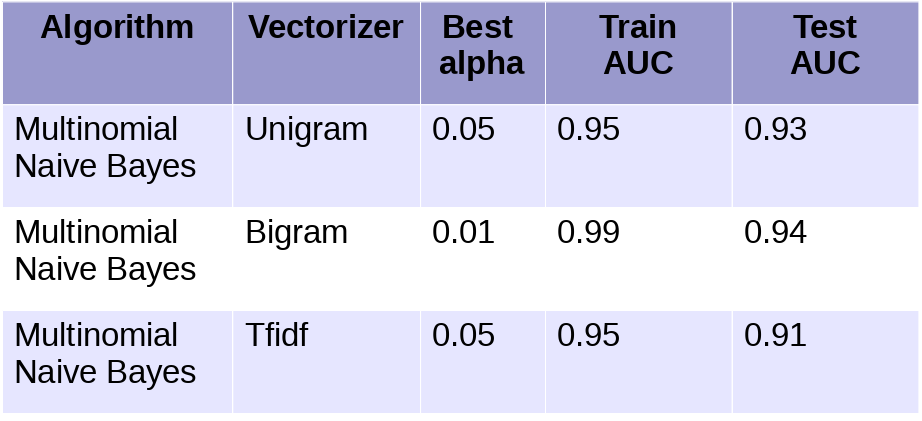

In [5]:
from IPython.display import Image
Image(filename="nb.png",height=500,width=500)